In [3]:
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\dyb\\.keras\\datasets\\auto-mpg.data'

In [7]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

In [11]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [22]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


In [23]:
# 注意这种拆分数据的方法
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

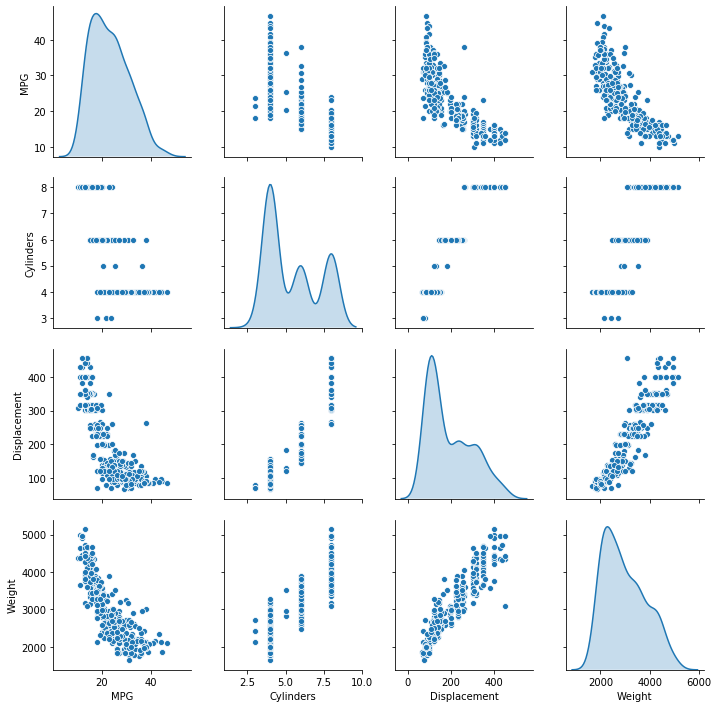

In [24]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [25]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [26]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [27]:
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [28]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse",
                 optimizer=optimizer,
                 metrics=["mae", "mse"])
    return model

In [29]:
model = build_model()

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [31]:
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
example_result

W1114 16:07:32.142131 108212 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


array([[-0.893635  ],
       [-0.92141986],
       [-0.6454212 ],
       [-0.08073404],
       [-0.05544173],
       [-0.6573342 ],
       [-0.44562292],
       [-0.6307119 ],
       [ 0.01289997],
       [-0.27984062]], dtype=float32)

In [32]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("")
        else:
            print(".", end="")

In [33]:
EPOCHS = 1000

history = model.fit(
        normed_train_data, train_labels,
        epochs=EPOCHS, validation_split=0.2, verbose=0,
        callbacks=[PrintDot()])

W1114 16:11:11.604261 108212 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


 
................................................................................................... 
................................................................................................... 
................................................................................................... 
................................................................................................... 
................................................................................................... 
................................................................................................... 
................................................................................................... 
................................................................................................... 
................................................................................................... 
.........................................................................................

In [35]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.661305,1.288479,3.661304,10.594121,2.371011,10.594121,995
996,3.457600,1.259011,3.457600,10.261462,2.310161,10.261462,996
997,3.546741,1.318931,3.546741,10.286555,2.322676,10.286555,997
998,3.558222,1.321100,3.558223,10.306890,2.309683,10.306890,998
999,3.684729,1.319990,3.684729,10.177535,2.364171,10.177536,999


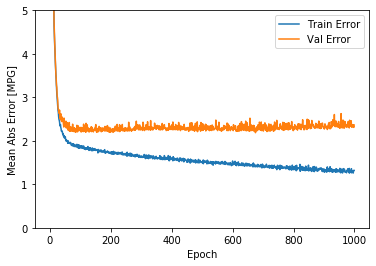

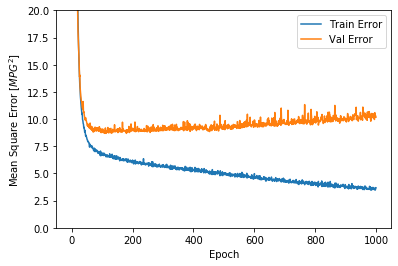

In [37]:
import matplotlib.pyplot as plt

def plot_history(history):
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Abs Error [MPG]')
      plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mae'],
               label = 'Val Error')
      plt.ylim([0,5])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Square Error [$MPG^2$]')
      plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
      plt.ylim([0,20])
      plt.legend()
      plt.show()


plot_history(history)

W1114 16:19:21.292277 108212 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


 
.........................................................................................

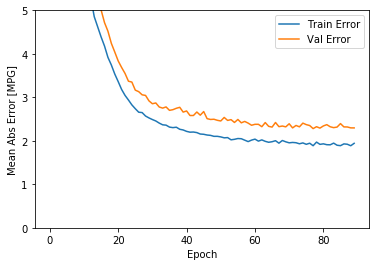

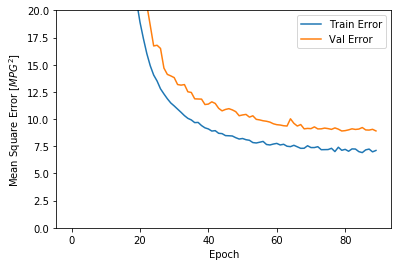

In [38]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [39]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Test set Mean Abs Error: {:5.2} MPG".format(mae))

W1114 16:21:31.359051 108212 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


78/78 - 0s - loss: 7.4386 - mae: 2.1929 - mse: 7.4386
Test set Mean Abs Error:   2.2 MPG


W1114 16:23:50.379507 108212 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Text(0, 0.5, 'Predictions [MPG]')

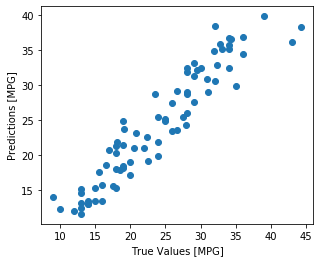

In [40]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

W1114 16:24:01.813276 108212 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


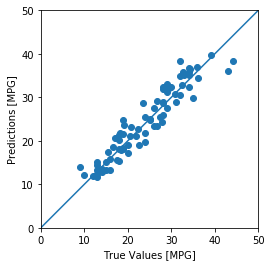

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

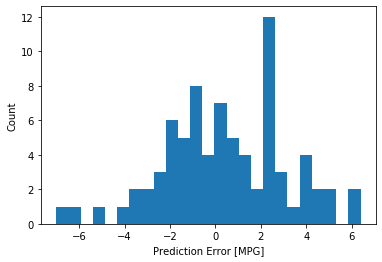

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")